## 1. MPG

**1) 자동차 모델의 여러 정보들을 이용하여 차량의 mpg를 예측하는 모델을 만들 것입니다. mpg를 예측하는 최적의 모델을 만드세요.**

In [1]:
import pandas as pd
import numpy as np
import os
import warnings 
import seaborn as sns
warnings.filterwarnings(action='ignore') 


from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

os.chdir('/Users/heeyoon/Documents/::2020_겨울/TNT/2주차/')

In [2]:
mpg = pd.read_csv('mpg.csv')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [3]:
## PREPROCESSING

# drop null data
mpg.dropna(inplace = True)

# one-hot-encoding :: origin
mpg_origin = pd.get_dummies(mpg['origin'])
mpg_encoded = pd.concat([mpg, mpg_origin], axis = 1)

# x, y, split
x = mpg_encoded[['cylinders', 'displacement', 'horsepower', 'weight',
                 'acceleration', 'model_year', 'europe', 'japan', 'usa']]
y = mpg_encoded[['mpg']]

x.head(5)

,cylinders,displacement,horsepower,weight,acceleration,model_year,europe,japan,usa
0,8,307.0,130.0,3504,12.0,70,0,0,1
1,8,350.0,165.0,3693,11.5,70,0,0,1
2,8,318.0,150.0,3436,11.0,70,0,0,1
3,8,304.0,150.0,3433,12.0,70,0,0,1
4,8,302.0,140.0,3449,10.5,70,0,0,1


In [4]:
## make function :: get Adjusted R-Square of linear, lasso, ridge, elasticNet

def get_adjustedR2(x, y):
    linear = linear_model.LinearRegression()
    ridge = linear_model.Ridge(alpha = 0.01)
    lasso = linear_model.Lasso(alpha = 0.001, max_iter = 1000)
    enet = linear_model.ElasticNet(alpha = 0.001, l1_ratio = 0.1)
    
    models = [linear, ridge, lasso, enet]
    models_ar2 = []
    fitted_models = []
    
    for model in models:
        fitted_model = model.fit(x, y)
        r2 = fitted_model.score(x, y)
        ar2 = 1 - ((1 - r2)*(x.shape[0] - 1)/(x.shape[0] - x.shape[1] - 1))
        
        models_ar2.append(ar2)
        fitted_models.append(fitted_model)
        
    
    results = pd.DataFrame(data = models_ar2, columns = ['Adjusted R-Square'], 
                           index = ['Linear', 'Ridge', 'Lasso', 'ElasticNet'])
    
    return results, fitted_models

In [5]:
## get results using basic x

result1, fitted_models1 = get_adjustedR2(x, y)
result1

,Adjusted R-Square
Linear,0.820058
Ridge,0.820058
Lasso,0.820057
ElasticNet,0.820057


In [6]:
## get results using PCA

x_scaled = StandardScaler().fit_transform(x)

pca = PCA(n_components = 4)
x_pc = pca.fit_transform(x_scaled)
x_pc = pd.DataFrame(data = x_pc, columns = ['PC1', 'PC2', 'PC3', 'PC4'])

result2, fitted_models2 = get_adjustedR2(x_pc, y)
result2

,Adjusted R-Square
Linear,0.771908
Ridge,0.771908
Lasso,0.771908
ElasticNet,0.771908


In [7]:
## multicollinearity checking

sm_model = sm.OLS(y, x)
sm_result = sm_model.fit()

vif_df = pd.DataFrame({'x': column, 'VIF': variance_inflation_factor(sm_model.exog, i)}
                      for i, column in enumerate(sm_model.exog_names)
                      if column != 'Intercept') 

vif_df

,x,VIF
0,cylinders,10.737771
1,displacement,22.937950
2,horsepower,9.957265
3,weight,11.074349
4,acceleration,2.625906
5,model_year,1.301373
6,europe,131.742634
7,japan,158.310491
8,usa,490.166631


In [8]:
# get result using x without usa

result3, fitted_models3 = get_adjustedR2(x[['cylinders', 'displacement', 'horsepower', 'weight',
                 'acceleration', 'model_year', 'europe', 'japan']], y)
result3

,Adjusted R-Square
Linear,0.820527
Ridge,0.820527
Lasso,0.820527
ElasticNet,0.820524


Linear Regression, Ridge Regression, Lasso Regression 그리고 ElasticNet, 총 4가지 모델을 이용해, 기존 데이터와 PC를 적용한 데이터, VIF를 이용해 usa 변수를 제거한 데이터를 회귀분석 해보았다. 결과적으로 VIF가 가장 높은 usa 를 제거한 회귀 예측모델이 전반적으로 Adjusted R-Square 점수가 가장 높았으며, 그 중 Linear, Ridge, Lasso 가 가장 좋은 성능을 보였다.

**2) 1번에서 만든 모델을 이용하여 mpg와 각각의 변수 간의 관계를 설명하세요.**

In [9]:
fitted_models3[0].coef_

array([[-0.48970942,  0.02397864, -0.01818346, -0.00671038,  0.07910304,
         0.77702694,  2.63000236,  2.85322823]])

mpg와 각각의 변수 간의 관계는 coefficient 를 통해 알 수 있다. 차량 실린더의 개수, 마력, 무게는 각각 1씩 증가할수록 차량의 연비는 감소하고, 
배기량, 차량가속, 모델 제작연도가 1씩 증가할수록 연비도 함께 증가한다. 가장 큰 영향을 미치는 변수는 japan으로 차량 제작 국가가 일본일 경우 연비가 2.85정도씩 증가함을 알 수 있다.

## 2. Concrete

**1) 주어진 데이터를 이용하여 최적의 Concrete Compressive strength를 예측하는 모델을 만들 것입니다. Concrete compressive strength(MPa)를 예측하는 최적의 모델을 만드세요.**

In [10]:
concrete = pd.read_csv('concrete_train.csv', index_col = 0)
concrete

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,277.0,0.0,0.0,191.0,0.0,968.0,856.0,28,25.97
1,359.0,19.0,141.0,154.0,10.9,942.0,801.0,3,25.12
2,272.8,181.9,0.0,185.7,0.0,1012.4,714.3,28,31.38
3,366.0,187.0,0.0,191.0,7.0,824.0,757.0,28,65.91
4,212.6,0.0,100.4,159.4,10.4,1003.8,903.8,3,13.33
...,...,...,...,...,...,...,...,...,...
819,284.0,119.7,0.0,168.3,7.2,970.4,794.2,28,40.93
820,280.0,129.0,100.0,172.0,9.0,825.0,805.0,28,52.82
821,141.3,212.0,0.0,203.5,0.0,971.8,748.5,90,39.66
822,135.0,0.0,166.0,180.0,10.0,961.0,805.0,28,13.29


In [11]:
# x, y, split

x = concrete[['cement', 'slag', 'flyash', 'water', 'superplasticizer', 'coarseaggregate', 'fineaggregate', 'age']]
y = concrete[['csMPa']]

x.head(5)

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
0,277.0,0.0,0.0,191.0,0.0,968.0,856.0,28
1,359.0,19.0,141.0,154.0,10.9,942.0,801.0,3
2,272.8,181.9,0.0,185.7,0.0,1012.4,714.3,28
3,366.0,187.0,0.0,191.0,7.0,824.0,757.0,28
4,212.6,0.0,100.4,159.4,10.4,1003.8,903.8,3


In [12]:
## get results using basic x

result1, fitted_models1 = get_adjustedR2(x, y)
result1

,Adjusted R-Square
Linear,0.630166
Ridge,0.630166
Lasso,0.630166
ElasticNet,0.630166


In [13]:
## get results using PCA

x_scaled = StandardScaler().fit_transform(x)

pca = PCA(n_components = 6)
x_pc = pca.fit_transform(x_scaled)
x_pc = pd.DataFrame(data = x_pc, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])

# 5 (pca.explained_variance_ratio_) 0.8731131981547622
# 6 (pca.explained_variance_ratio_) 0.9728628548848929

result2, fitted_models2 = get_adjustedR2(x_pc, y)
result2

,Adjusted R-Square
Linear,0.582621
Ridge,0.582621
Lasso,0.582621
ElasticNet,0.582621


In [14]:
## multicollinearity checking

sm_model = sm.OLS(y, x)
sm_result = sm_model.fit()

vif_df = pd.DataFrame({'x': column, 'VIF': variance_inflation_factor(sm_model.exog, i)}
                      for i, column in enumerate(sm_model.exog_names)
                      if column != 'Intercept') 

vif_df

,x,VIF
0,cement,14.902703
1,slag,3.173922
2,flyash,4.294063
3,water,80.312043
4,superplasticizer,5.381436
5,coarseaggregate,88.239411
6,fineaggregate,74.420410
7,age,1.671114


In [15]:
# get result using x without origin

result3, fitted_models3 = get_adjustedR2(x[['cement', 'slag', 'flyash', 'water', 'superplasticizer', 
                 'fineaggregate', 'age']], y)
result3

,Adjusted R-Square
Linear,0.629316
Ridge,0.629316
Lasso,0.629316
ElasticNet,0.629316


In [16]:
## get results using polyFeatures

from sklearn.preprocessing import PolynomialFeatures

preprocess_poly2 = PolynomialFeatures(degree = 2)
x_poly = preprocess_poly2.fit_transform(x)

result3, fitted_models3 = get_adjustedR2(x_poly, y)
result3

,Adjusted R-Square
Linear,0.812040
Ridge,0.812039
Lasso,0.801709
ElasticNet,0.801712


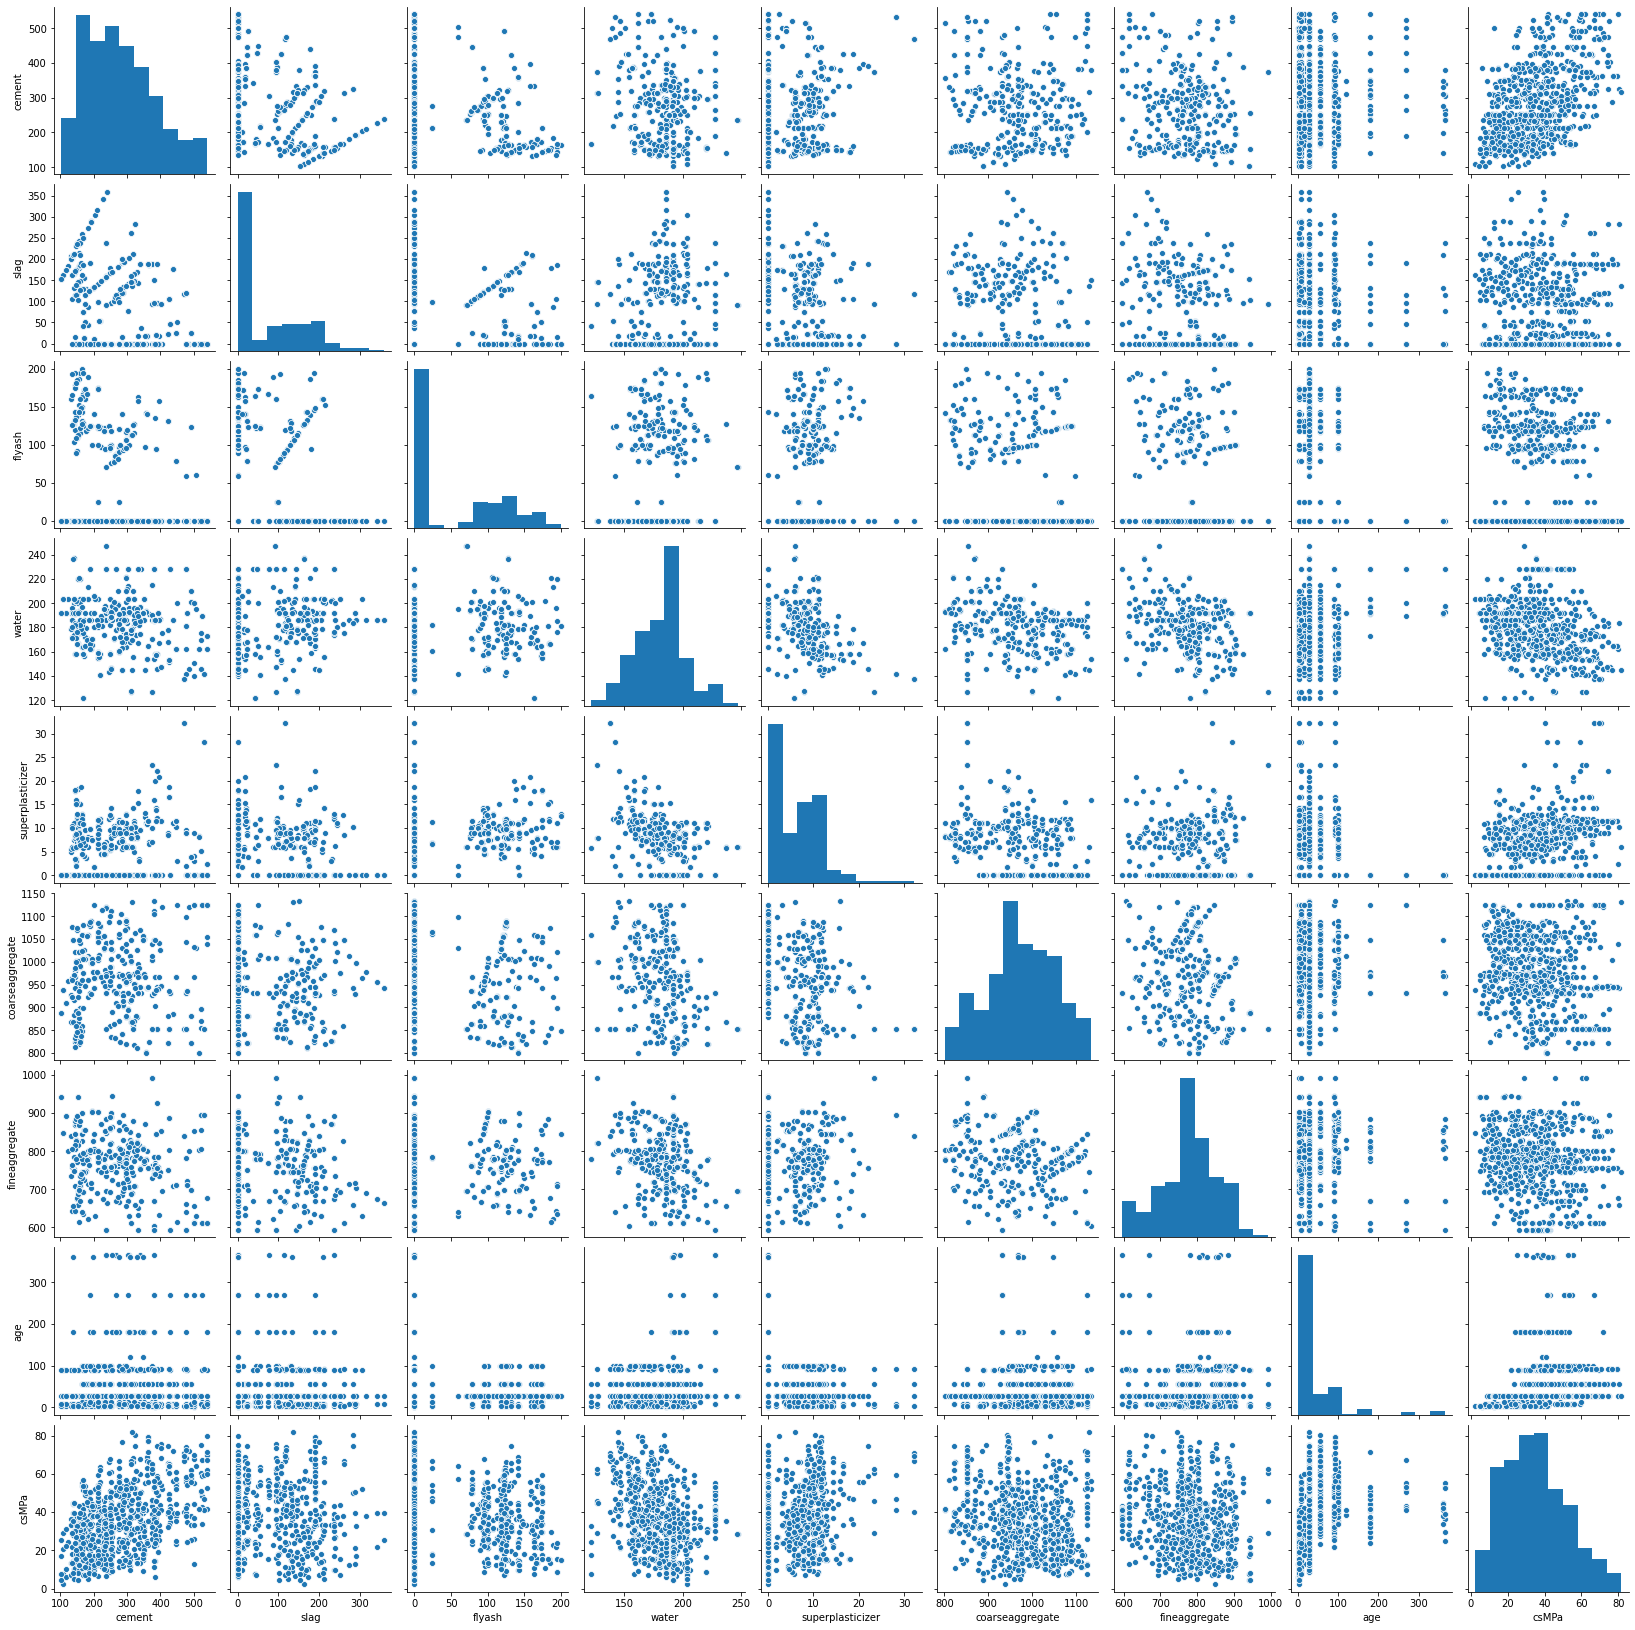

In [17]:
sns.pairplot(concrete)

**2) 1) 에서 만든 모델을 이용하여 Mpa와 각각 변수간의 관계를 설명하세요.**

In [18]:
fitted_models1[0].coef_

array([[ 0.12424381,  0.10766686,  0.091274  , -0.13804472,  0.36192166,
         0.01718424,  0.01984496,  0.12008255]])

일단, pairplot을 통해서도 볼 수 있듯이 csMPa와 다른 변수들의 관계가 선형적이지 않다. 또한 x 변수들은 서로 선형적인 관계가 아닌 고르게 퍼져 있는 분포를 보여 독립변수들 간에 다중공선성이 있다고 말하기 어렵다. 결과적으로 PCA를 거친 모델링의 Adjusted R-Sqaure 값이 가장 낮았고, 비선형 데이터를 적합시킬 수 있도록 하는 polynomial regression의 결과가 가장 좋았다. 

기본 데이터를 이용한 선형회귀 중 가장 좋은 모델인 Linear Regression의 coefficient 값을 통해 MPa와 각 변수 간의 관계를 알 수 있다. water 변수만 유일하게 1씩 증가할 수록 콘크리트의 내구성이 저하되고, 나머지 변수들은 값이 증가할 수록 콘그리트의 내구성도 강해진다. 그 중 superplasticizer가 1씩 증가하면 0.36씩 콘크리트 내구성이 증가해, 가장 큰 영향을 미친다고 해석 할 수 있다. polynomial regression의 측면에서는 변수 간의 교호작용이 모델의 성능을 높였다고 볼 수 있다. 

**3) 1)에서 만든 모델의 test_mse를 구하세요.**

In [19]:
concrete_test = pd.read_csv('concrete_test.csv', index_col = 0)
concrete_test

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,297.2,0.0,117.5,174.8,9.5,1022.8,753.5,3,21.91
1,238.1,0.0,94.1,186.7,7.0,949.9,847.0,3,19.93
2,140.0,133.0,103.0,200.0,7.0,916.0,753.0,28,36.44
3,203.5,135.7,0.0,185.7,0.0,1076.2,759.3,7,11.96
4,162.0,207.0,172.0,216.0,10.0,822.0,638.0,28,39.84
...,...,...,...,...,...,...,...,...,...
201,212.5,0.0,100.4,159.3,8.7,1007.8,903.6,100,42.92
202,255.0,0.0,0.0,192.0,0.0,889.8,945.0,3,8.20
203,359.0,19.0,141.0,154.0,10.9,942.0,801.0,7,38.61
204,310.0,0.0,0.0,192.0,0.0,970.0,850.0,90,34.68


In [20]:
x_test = concrete_test[['cement', 'slag', 'flyash', 'water', 'superplasticizer', 
                 'coarseaggregate', 'fineaggregate', 'age']]
y_test = concrete_test[['csMPa']]

In [21]:
test_pred1 = fitted_models1[0].predict(x_test)
print(mean_squared_error(y_test, test_pred1))

124.86942797172925


In [22]:
x_test_poly = preprocess_poly2.fit_transform(x_test)
test_pred2 = fitted_models3[0].predict(x_test_poly)

print(mean_squared_error(y_test, test_pred2))

67.29932025439942


Linear Regression 과 Polynomial Regression을 통해 구한 mse는 각각 125.87, 67.30 로 Polynomial Regression가 더 좋은 결과를 보였다.